In [4]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings('ignore')

In [5]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, InputLayer, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.utils import multi_gpu_model

import keras_metrics
import pandas
import ast
import numpy as np
from PIL import Image

In [6]:
import keras.backend as K
import numpy as np
import random

def yolf_loss(y_true, y_pred):
    b_xy_pred = y_pred[..., :2]
    b_wh_pred = y_pred[..., 2:4]
    b_xy = y_true[..., 0:2]
    b_wh = y_true[..., 2:4]
    #print(b_xy_pred.get_shape(),b_xy.get_shape())
    #print(b_wh_pred.get_shape(),b_wh.get_shape())
    
    #indicator_coord = K.expand_dims(y_true[..., 3], axis=-1) * 1.0

    loss_xy = K.sum(K.square(b_xy - b_xy_pred), axis=-1)# * indicator_coord)#, axis=[1,2,3,4])
    loss_wh = K.sum(K.square(K.sqrt(b_wh) - K.sqrt(b_wh_pred)), axis=-1)# * indicator_coord)#, axis=[1,2,3,4])
    
    return (loss_wh + loss_xy)/2



In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
train_set = "/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/train/"
validation_set = "/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/val/"
test_set = "/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/test/"

In [9]:
train_df = pandas.read_csv("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/train/output_final.csv")
valid_df = pandas.read_csv("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/val/output_final.csv")
test_df = pandas.read_csv("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/test/output_final.csv")

In [10]:
print("Media x",valid_df.x_1.mean(), "stdev" ,valid_df.x_1.std() )
print("Media y",valid_df.y_1.mean(), "stdev" ,valid_df.y_1.std() )
print("Media width",valid_df.width.mean(), "stdev" ,valid_df.width.std() )
print("Media height",valid_df.height.mean(), "stdev" ,valid_df.height.std() )

Media x 64.62334101129757 stdev 26.993578345104307
Media y 32.69935285729955 stdev 15.22792311959398
Media width 95.49484479543709 stdev 36.539656449787245
Media height 109.07529889217945 stdev 40.39441074706963


In [8]:
train_df.head(2)

,Unnamed: 0,image_id,x_1,y_1,width,height
0,0,021905.jpg,57,37,133,123
1,1,013220.jpg,72,27,78,92


from PIL import Image, ImageDraw
path_train_image = train_set
count = 0 
for index,row in train_df.iterrows(): 
    count = count +1 
    img_path = path_train_image + "/" + row['image_id']
    im = Image.open(img_path)
    x,y,w,h =row['x_1'],row['y_1'],row['width'],row['height']
    print(x,y,w,h)  
    #plt.imshow(img) 
    draw = ImageDraw.Draw(im)
    draw.rectangle(((x, y), (x+w, y+h)))
    display(im)
    # Add the patch to the Axes 
    if count == 2: 
        break

In [11]:
BATCH_SIZE = 256
IMG_SIZE = 224
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.4,1.0])

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_set,
        x_col="image_id",
        y_col=["x_1","y_1","width","height"],
        class_mode="raw",
        #shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=validation_set,
        x_col="image_id",
        y_col=["x_1","y_1","width","height"],
        class_mode="raw",
        #shuffle=True,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 164105 validated image filenames.
Found 18234 validated image filenames.


In [10]:
step_size_train = train_generator.samples/train_generator.batch_size
step_size_valid = valid_generator.samples/valid_generator.batch_size

In [11]:
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
          
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(1,1), activation="relu"))
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))

model.add(GlobalAveragePooling2D())

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

#model.add(Flatten())
model.add(Conv2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(2622, (1, 1)))

In [13]:
rule_4_neurons_number = [int(round(x/(i+1),0)) for (x,i) in zip([1024]*2,
                                           range(2))]

In [14]:
model.add(Dense(rule_4_neurons_number[0], activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(rule_4_neurons_number[1], activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [16]:
model = multi_gpu_model(model, gpus=2) #parallelize model

In [17]:
model.compile(optimizer=Adam(lr = 1e-5), loss=yolf_loss, metrics=["accuracy"])

In [18]:
model.evaluate_generator(valid_generator, steps=step_size_valid, verbose = 1)


72/71 [==============================] - 48s 660ms/step


[3360.4677734375, 0.22414171695709229]

In [19]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=60, verbose=1, mode='min')
mcp_save = ModelCheckpoint('yolf.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='min')

history = model.fit_generator(generator=train_generator, epochs=100, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=1, callbacks=[mcp_save, earlyStopping, reduce_lr_loss])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
642/641 [==============================] - 475s 740ms/step - loss: 571.8966 - accuracy: 0.2263 - val_loss: 265.0954 - val_accuracy: 0.2256
Epoch 2/100
642/641 [==============================] - 473s 736ms/step - loss: 236.1400 - accuracy: 0.3008 - val_loss: 188.8410 - val_accuracy: 0.3620
Epoch 3/100
642/641 [==============================] - 491s 764ms/step - loss: 171.5799 - accuracy: 0.4030 - val_loss: 79.3686 - val_accuracy: 0.5060
Epoch 4/100
642/641 [==============================] - 486s 757ms/step - loss: 140.3509 - accuracy: 0.4588 - val_loss: 113.6247 - val_accuracy: 0.5296
Epoch 5/100
642/641 [==============================] - 473s 736ms/step - loss: 119.9878 - accuracy: 0.4896 - val_loss: 49.9522 - val_accuracy: 0.5536
Epoch 6/100
642/641 [==============================] - 461s 718ms/step - loss: 105.7709 - accuracy: 0.5030 - val_loss: 70.6362 - val_accuracy: 0.5669
Epo

In [20]:
#print(history.history)

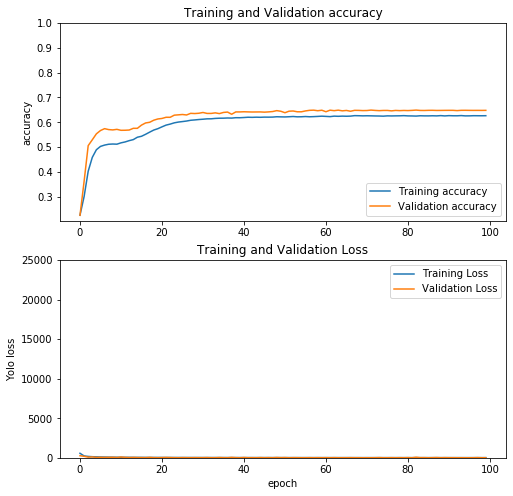

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Yolo loss')
plt.ylim([0,25000])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
import pandas as pd
dict_data = history.history
df = pd.DataFrame.from_dict(dict_data, dtype=float)
csv_file = "yolf2.csv"
df.to_csv(csv_file)

model_json = model.to_json()
with open("yolf2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("resnet50.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
import keras

In [13]:
json_file = open('yolf2.json', 'r') 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = keras.models.model_from_json(loaded_model_json) 
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            21390596    lambda_1[0][0]                   
                                                                 lambda_2[0][0]             

In [14]:
#load weights into new model 
loaded_model.load_weights("yolf.h5") 
print("Loaded model from disk") 
#evaluate loaded model on test data 
loaded_model.compile( optimizer= keras.optimizers.Adam(lr=1e-4), 
loss = keras.losses.categorical_crossentropy, metrics=['accuracy'])

Loaded model from disk


In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                    directory=test_set,
                                    x_col="image_id",
                                    y_col=["x_1","y_1","width","height"],
                                    class_mode="raw",
                                    shuffle=True,
                                    target_size=(IMG_SIZE, IMG_SIZE),
                                    batch_size=BATCH_SIZE)

STEP_SIZE_TEST = test_generator.n / test_generator.batch_size 


#CHANGE PARALLEL MODEL
pred=loaded_model.predict_generator(test_generator,  steps=STEP_SIZE_TEST,  verbose=1)

Found 20260 validated image filenames.

80/79 [==============================] - 33s 407ms/step


In [17]:
print(pred[1],pred[2],pred[3])

[65.7348   35.533726 75.08704  86.57357 ] [78.84282   9.634201 66.534645 81.24601 ] [ 49.349197  33.966312  98.17223  110.978935]


In [18]:
from PIL import  Image, ImageDraw

count = 0

for gen_image in test_generator:
    img = Image.fromarray(np.uint8((gen_image[0][0])*255))
    img1 = ImageDraw.Draw(img)
    x1,y1 = pred[count][0],pred[count][1]
    x4,y4= pred[count][0] + pred[count][2], pred[count][1] + pred[count][3]
    img1.rectangle([(x1,y1),(x4,y4)], outline ="red") 
    #img.show() 
    img.save("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/NUOVO/results_yolf_v2/output"+ str(count) + ".jpg")
    #print(gen_image[0][0].shape,pred[count])
    count = count + 1
    if count == 200:
        break